This notebook shows how fatalities can be predicted as a lag of confirmed cases.  This model confirms clinical observation about duration of disease in case of fatal outcome.

First some imports

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

import datetime
import gc

Reading data.  We introduce and normalize days since data starting date, as well as a geo column for all country/province pairs.  Last, we define our validation data to be data from first test day to last train day included.

In [2]:
train = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-2/train.csv')
train['Province_State'].fillna('', inplace=True)
train['Date'] = pd.to_datetime(train['Date'])
train['day'] = train.Date.dt.dayofyear
train['geo'] = ['_'.join(x) for x in zip(train['Country_Region'], train['Province_State'])]

test = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-2/test.csv')
test['Province_State'].fillna('', inplace=True)
test['Date'] = pd.to_datetime(test['Date'])
test['day'] = test.Date.dt.dayofyear
test['geo'] = ['_'.join(x) for x in zip(test['Country_Region'], test['Province_State'])]

day_min = train['day'].min()
train['day'] -= day_min
test['day'] -= day_min

min_test_val_day = test.day.min()
max_test_val_day = train.day.max()
max_test_day = test.day.max()
num_days = max_test_day + 1

min_test_val_day, max_test_val_day, num_days

(57, 69, 100)

From now on we will just work with training data.  When submitting to the competition we of course need to make predictions for the full test set.  This part is left out of the introductory notebook but can be seen in one of our two selected submissions.

In [3]:
data = train
del train, test 
gc.collect()

0

Let's now turn data into matrices with geos as rows, amd days as columns.  For this we use the convenient pivot from pandas.  We will also apply log1p rescaling so that the competition metric becomes root mean squared error.

In [4]:
cases = np.log1p(data.pivot(index='geo', columns='day', values='ConfirmedCases'))
deaths = np.log1p(data.pivot(index='geo', columns='day', values='Fatalities'))
num_geo = cases.shape[0]

Now, let's make some plots to see if fatalities curve is following or not the confirmed case curves.  The following assumes a 8 day delay between when people are confirmed case and when they die, for those who die.  We see that the green curve is rather flat, which confirms there is a linear dependancy between when people are diagnosed and when they die. We also see that the proportion of fatalities is not the same across countries: the green curve height varies from geo to geo.

Italy_


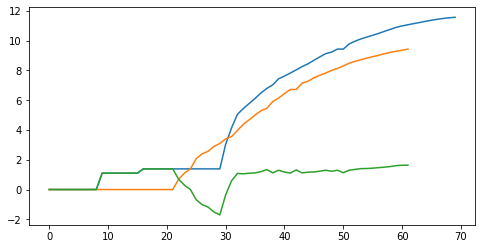

France_


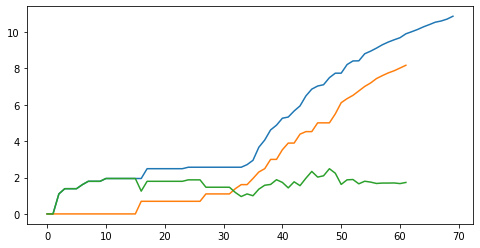

Spain_


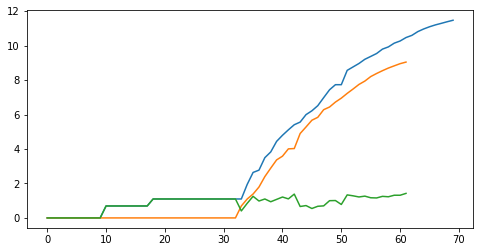

China_Hubei


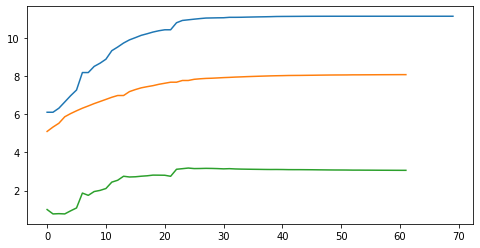

Germany_


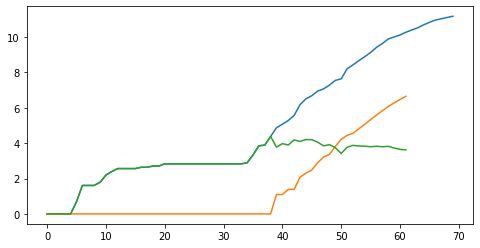

Afghanistan_


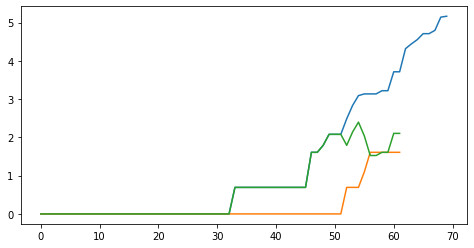

In [5]:
max_date = max_test_val_day
delta = 8
geos = ['Italy_', 'France_', 'Spain_', 'China_Hubei', 'Germany_', 'Afghanistan_']
for geo in geos:
    print(geo)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(cases.loc[geo, :max_date].values)
    ax.plot(deaths.loc[geo, delta:max_date].values)
    ax.plot(cases.loc[geo, :max_date-delta].values - deaths.loc[geo, delta:max_date].values)
    plt.show()

Plots with delta equal to 7 looks almost as good.  other values see a degradation of the curve, as shown for Spain:

6


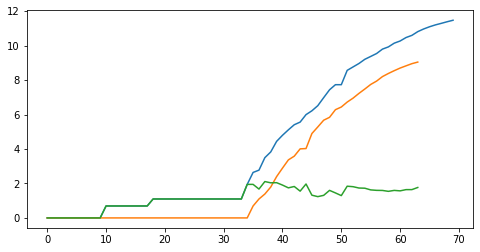

7


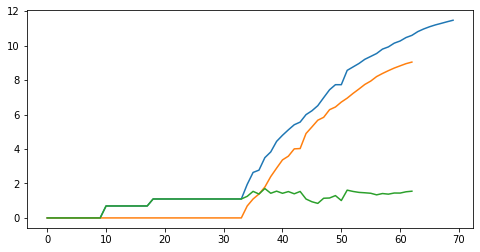

8


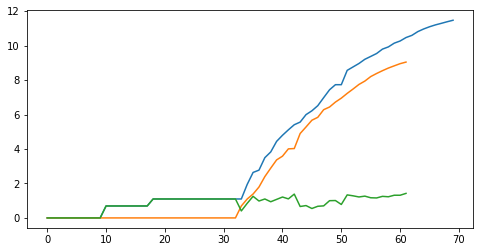

9


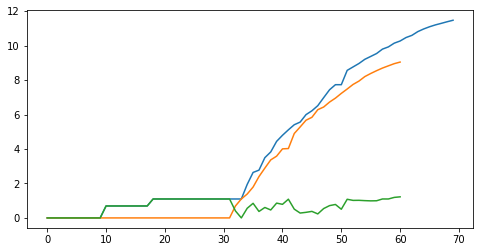

10


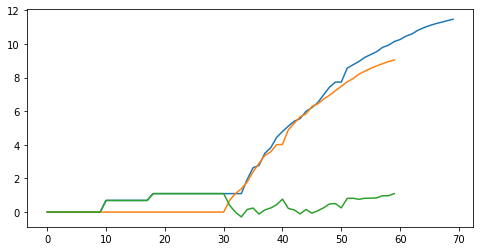

In [6]:
max_date = max_test_val_day
geo = 'Spain_'
for delta in range(6, 11):
    print(delta)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(cases.loc[geo, :max_date].values)
    ax.plot(deaths.loc[geo, delta:max_date].values)
    ax.plot(cases.loc[geo, :max_date-delta].values - deaths.loc[geo, delta:max_date].values)
    plt.show()

Let's model this.  The first thing to do is to create datasets for training and validation.  A dataset will be defined by a `start_pred` day.  It will have `lag_period` past confirmed cases data prior to that day, as well as previous day cumulated deaths, and fatailities target for the day.  We further refine this by allowing the creation of `num_train` datasets for several days, and concatenating them.  

In [7]:
def get_dataset(start_pred, num_train, lag_period):
    days = np.arange( start_pred - num_train + 1, start_pred + 1)
    lag_cases = np.vstack([cases.iloc[:, d - lag_period : d] for d in days])
    lag_deaths = np.vstack([deaths.iloc[:, d - 1 : d] for d in days])
    target_deaths = np.vstack([deaths.iloc[:, d : d + 1] for d in days])
    return lag_cases, lag_deaths, target_deaths

We can now define our procedure for training our model.  We will use scikit-learn linear regression.  More specifically we will use the L2 regularized version of it, called Ridge.  Our procedure takes as input a dataset and a Ridge model.  It fits it to the data then computes a score.  We also add an optoin to only compute the score without fitting the model.  This will be useful for validation.

In [8]:
def val_score(true, pred):
    return np.sqrt(mean_squared_error(true.ravel(), pred.ravel()))

def fit_eval(lr, data, fit):
    lag_cases, lag_deaths, target_deaths = data
    
    X = np.hstack([lag_cases, lag_deaths])
    y = target_deaths
    if fit:
        lr.fit(X, y)
    y_pred = lr.predict(X)
    score = val_score(y, y_pred)
    return score

Our main procedure trains a model, then computes its score on the validation data.  It takes as input a training dataset and a validation dataset.


In [9]:
def train_model(train_data, valid_data):
    lr = Ridge(fit_intercept=False)        
    train_score = fit_eval(lr, train_data, fit=True)
    valid_score = fit_eval(lr, valid_data, fit=False)   
    print('train: %0.4f' %  train_score,
          'val : %0.4f' %  valid_score,
          )
    return train_score, valid_score

Let's try it for the train/validation split we discussed earlier. The values for `num_train` and `lag_period` were found via grid search in previous runs of the final model.

In [10]:
num_train = 5
lag_period = 14

start_val = min_test_val_day
last_train = start_val - 1
train_data = get_dataset(last_train, num_train, lag_period)
valid_data = get_dataset(start_val, 1, lag_period)
_ = train_model(train_data, valid_data)
        
            

train: 0.1561 val : 0.2150


Testing on one validation day is a bit brittle, we should test on all the validation days we have.  For this we just need to get a larger validation dataset.  

In [11]:
last_val = max_test_val_day
last_train = min_test_val_day - 1
num_val = last_val - last_train

train_data = get_dataset(last_train, num_train, lag_period)
valid_data = get_dataset(last_val, num_val, lag_period)
_ = train_model(train_data, valid_data)
        

train: 0.1561 val : 0.1901


Similarly, we should use more than one training fold. 

In [12]:
def evaluate():
    train_scores = []
    valid_scores = []

    for start_val_delta in range(3, -8, -3):
        last_val = max_test_val_day
        last_train = min_test_val_day - 1 + start_val_delta
        num_val = last_val - last_train
        print(num_val, end='  ')
        train_data = get_dataset(last_train, num_train, lag_period)
        valid_data = get_dataset(last_val, num_val, lag_period)
        train_score, valid_score = train_model(train_data, valid_data)
        train_scores.append(train_score)
        valid_scores.append(valid_score)

    print('avg train: %0.4f val: %0.4f' % (np.mean(train_scores), np.mean(valid_scores), ))
    
evaluate()

10  train: 0.1896 val : 0.1802
13  train: 0.1561 val : 0.1901
16  train: 0.1356 val : 0.1856
19  train: 0.1371 val : 0.1821
avg train: 0.1546 val: 0.1845


We are predicting a cumul i.e. a function that increases over time.  Therefore, we should make our predictions at least as large as the previous say.  A simple tweak in our utility function does the job.

In [13]:
def fit_eval(lr, data, fit):
    lag_cases, lag_deaths, target_deaths = data
    X = np.hstack([lag_cases, lag_deaths])
    y = target_deaths
    if fit:
        lr.fit(X, y)
    y_pred = lr.predict(X)
    y_prev = lag_deaths[:, -1:]  # new
    y_pred = np.maximum(y_pred, y_prev) # new
    score = val_score(y, y_pred)
    return score

evaluate()

10  train: 0.1896 val : 0.1802
13  train: 0.1561 val : 0.1901
16  train: 0.1356 val : 0.1856
19  train: 0.1371 val : 0.1821
avg train: 0.1546 val: 0.1845


Improvement is too small to show, but good to have.  A way to improve Ridge model is to tune its regularization weight.  Increasing it helps a bit:

Let us now look at lag cases values.  Our current model depends on previous day confirmed cases which looks very unlikely.  What we should do is to restrict lag cases.  Let's introduce two more control parameters for that.

In [14]:
def get_dataset(start_pred, num_train, case_lag_start, case_lag_end):
    days = np.arange( start_pred - num_train + 1, start_pred + 1)
    lag_cases = np.vstack([cases.iloc[:, d - case_lag_start : d - case_lag_end ] for d in days]) # modified
    lag_deaths = np.vstack([deaths.iloc[:, d - 1 : d] for d in days]) 
    target_deaths = np.vstack([deaths.iloc[:, d : d + 1] for d in days])
    return lag_cases, lag_deaths, target_deaths

def evaluate(case_lag_start, case_lag_end ):
    train_scores = []
    valid_scores = []

    for start_val_delta in range(3, -8, -3):
        last_val = max_test_val_day
        last_train = min_test_val_day - 1 + start_val_delta
        num_val = last_val - last_train
        print(num_val, end='  ')
        train_data = get_dataset(last_train, num_train, case_lag_start, case_lag_end)
        valid_data = get_dataset(last_val, num_val, case_lag_start, case_lag_end)
        train_score, valid_score = train_model(train_data, valid_data)
        train_scores.append(train_score)
        valid_scores.append(valid_score)

    print('avg train: %0.4f val: %0.4f' % (np.mean(train_scores), np.mean(valid_scores), ))

In [15]:
    
case_lag_start, case_lag_end = 15,2
evaluate(case_lag_start, case_lag_end )

10  train: 0.1899 val : 0.1807
13  train: 0.1558 val : 0.1896
16  train: 0.1355 val : 0.1853
19  train: 0.1374 val : 0.1819
avg train: 0.1546 val: 0.1844


Allright, how can we model the different we noticed across countries?  One way is just to add an indicator variable for each geo.  We need to create it, and update our utility functions

In [16]:
countries = [g.split('_')[0] for g in cases.index]
countries = pd.factorize(countries)[0]
countries = countries.reshape((-1, 1))
ohe = OneHotEncoder(sparse=False)
geo_ids_base = ohe.fit_transform(countries)
geo_ids_base.shape

(294, 173)

In [17]:
def get_dataset(start_pred, num_train, case_lag_start, case_lag_end):
    days = np.arange( start_pred - num_train + 1, start_pred + 1)
    lag_cases = np.vstack([cases.iloc[:, d - case_lag_start : d - case_lag_end ] for d in days]) # modified
    lag_deaths = np.vstack([deaths.iloc[:, d - 1 : d] for d in days]) 
    target_deaths = np.vstack([deaths.iloc[:, d : d + 1] for d in days])
    geo_ids = np.vstack([geo_ids_base for d in days]) # modified
    return lag_cases, lag_deaths, target_deaths, geo_ids # modified

def fit_eval(lr, data, fit):
    lag_cases, lag_deaths, target_deaths, geo_ids = data # modified
    X = np.hstack([lag_cases, lag_deaths, geo_ids]) # modified
    y = target_deaths
    if fit:
        lr.fit(X, y)
    y_pred = lr.predict(X)
    y_prev = lag_deaths[:, -1:]  
    y_pred = np.maximum(y_pred, y_prev) 
    score = val_score(y, y_pred)
    return score

evaluate(case_lag_start, case_lag_end )

10  train: 0.1734 val : 0.1873
13  train: 0.1463 val : 0.1930
16  train: 0.1238 val : 0.1896
19  train: 0.1308 val : 0.1829
avg train: 0.1436 val: 0.1882


Using same train/valid split we now get a validation score degradation whiole trainings core improves a lot.  This is a symptom of overfiting to the features we just added.  A way to cope with this is to add more regularization of the coefficients for the added country features.  

One simple trick is to divide the features by a constant. Mechanically, the same model will need to multiply their coefficients by the same value. And regulariwzation cost for these coefficients will also be multiplied by the square of this value (roughly speaking). Let's try it.


In [18]:
countries = [g.split('_')[0] for g in cases.index]
countries = pd.factorize(countries)[0]
countries = countries.reshape((-1, 1))
ohe = OneHotEncoder(sparse=False)
geo_ids_base = ohe.fit_transform(countries)
geo_ids_base = 0.2 * geo_ids_base  # new

evaluate(case_lag_start, case_lag_end )

10  train: 0.1846 val : 0.1795
13  train: 0.1530 val : 0.1890
16  train: 0.1321 val : 0.1850
19  train: 0.1350 val : 0.1807
avg train: 0.1512 val: 0.1835


We now see some improvement of the validation score.